Dataset:

https://www.kaggle.com/uciml/electric-power-consumption-data-set/download

### Import libraries and dataset

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("household_power_consumption.txt", sep=';',
                 parse_dates={'dt' : ['Date','Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.shape

(2075259, 7)

In [2]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

We have so many null values in the dataset, I will fill these null values with the mean values:

In [3]:
df = df.fillna(df.mean())

### Data Visualization

Let's have a look at the data more closely by visualizing it:

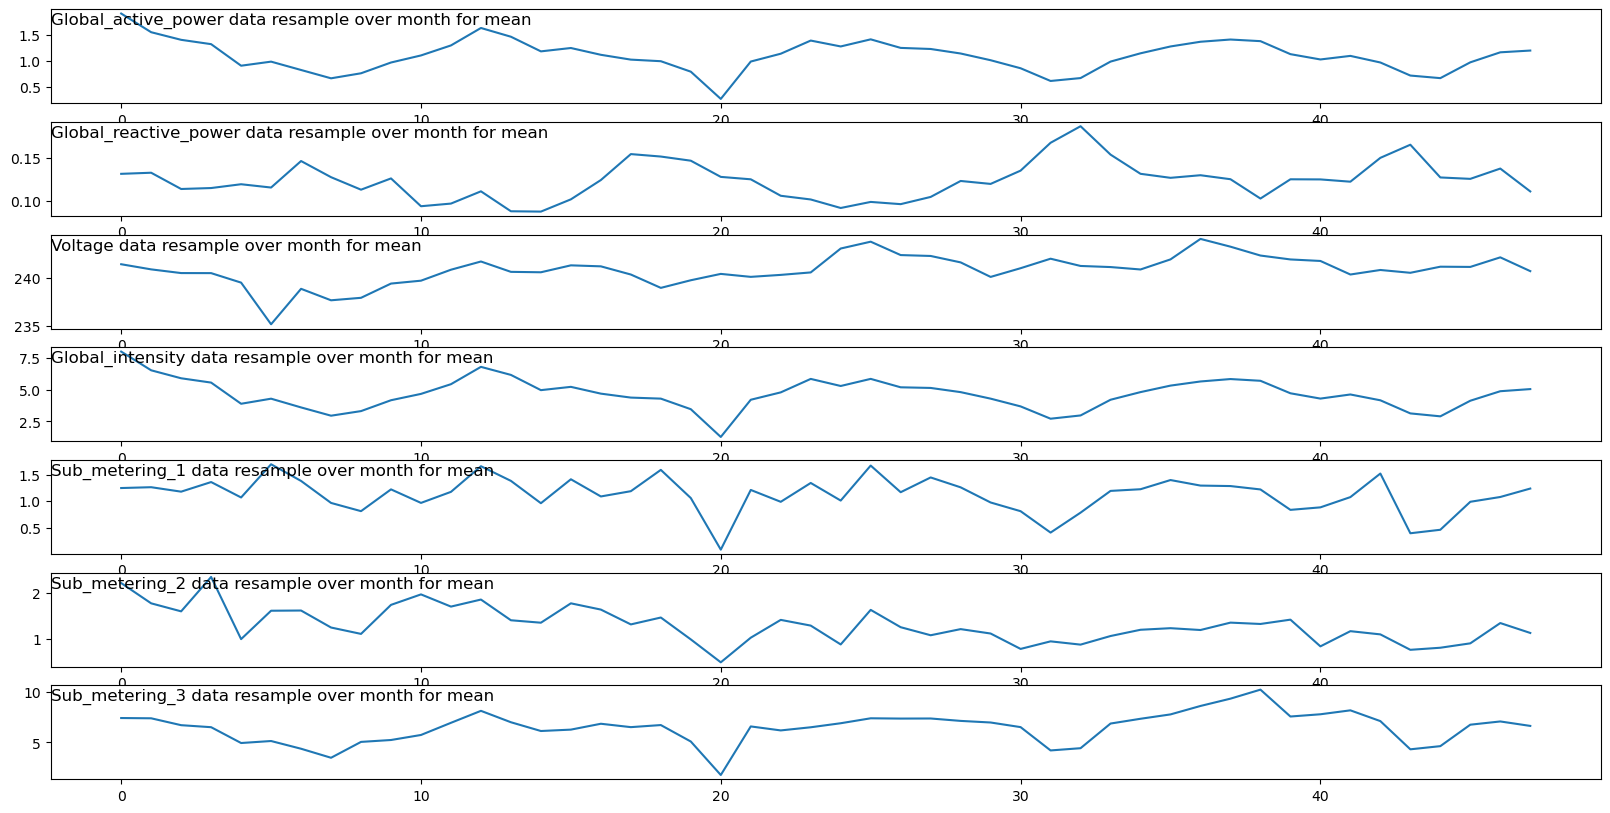

In [4]:
import matplotlib.pyplot as plt

i = 1
cols=[0,1,2,3,4,5,6]
plt.figure(figsize=(20,10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample("M").mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

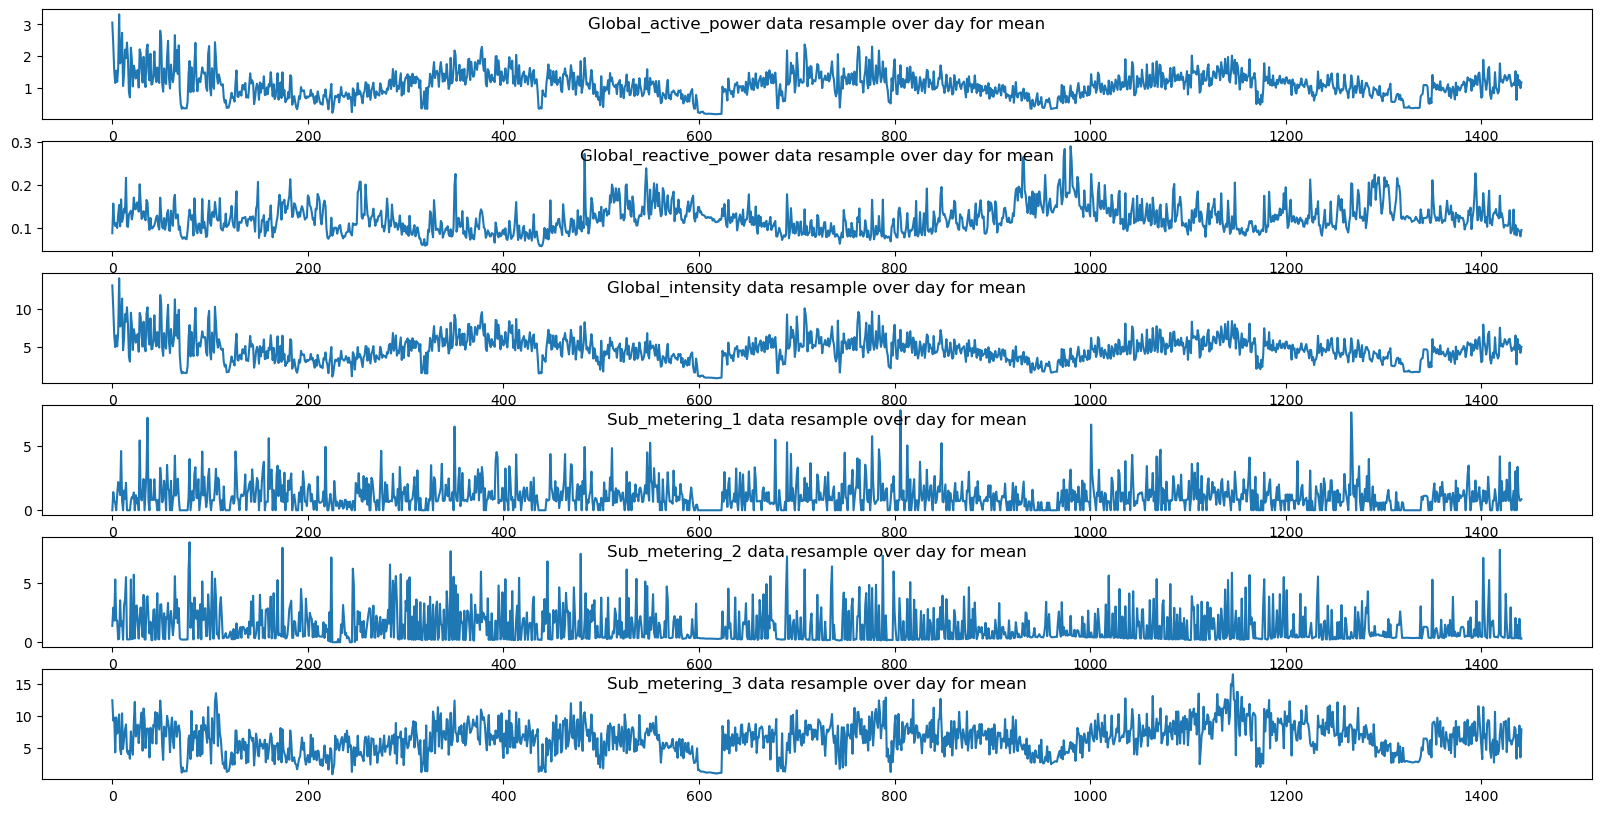

In [5]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

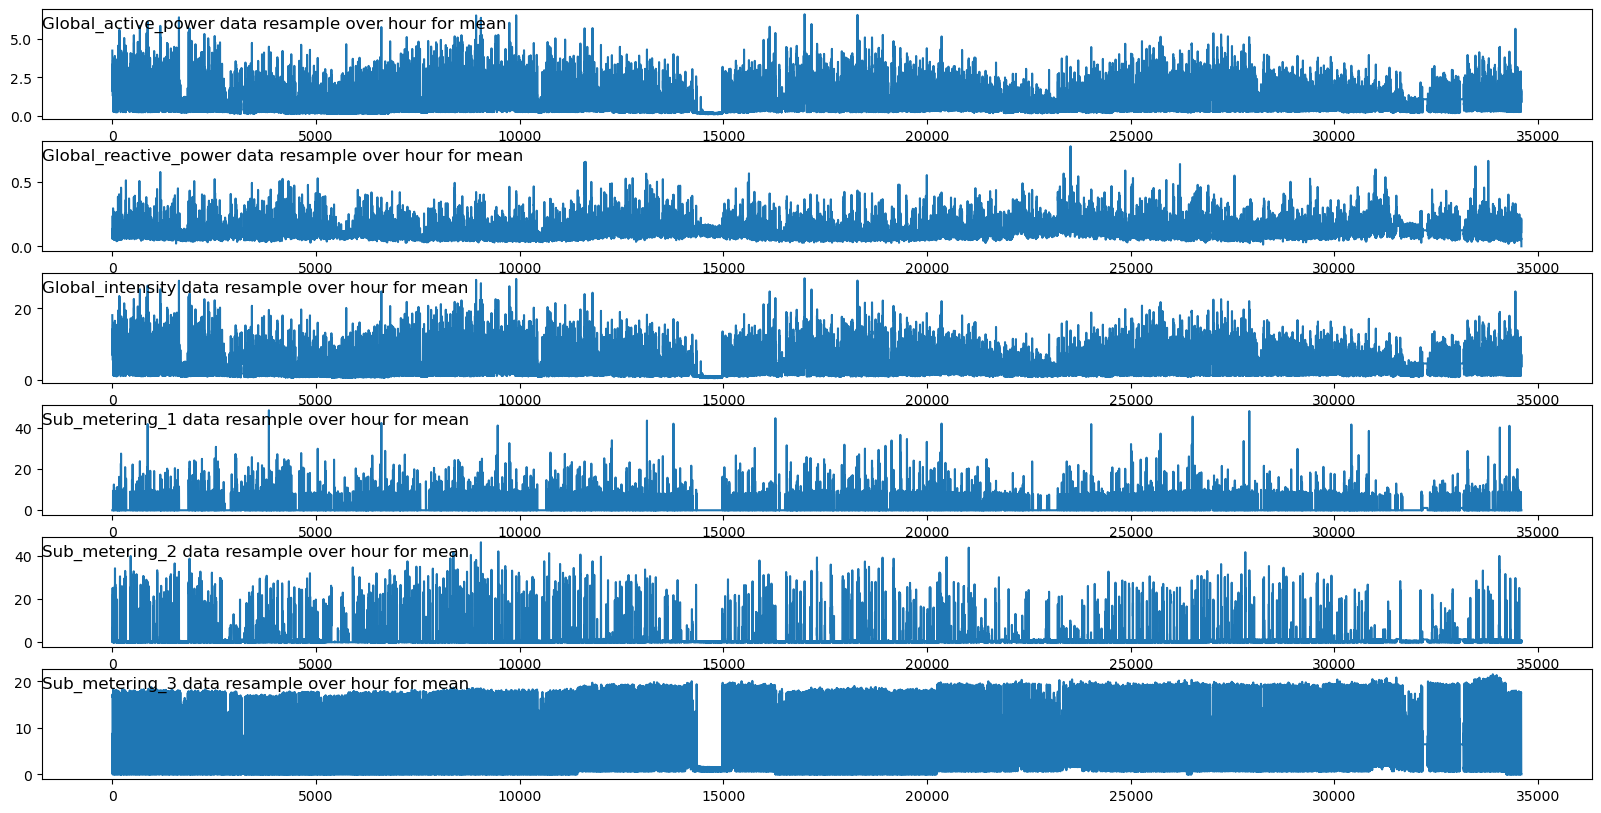

In [6]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

Observations from the above visualizations:

1. Resampling by month, date or time is very important because it has a great interaction as expected (changing the periodicity of the system).

2. Therefore, if you process all the original data, the run time will be very expensive, but if you process data with large timescale samples (e.g., monthly), it will affect the predictability of the model.

3. From observation, we can see it is relatively reasonable to resample the data per hour.

### Using the LSTM Model

For the task of energy consumption prediction with Machine Learning, I will use the LSTM model because it is very well suited for large time-series data. I’ll start this step by preparing a helper function to frame the problem:

In [7]:
df = df[['Global_active_power','Global_reactive_power','Voltage',
         'Global_intensity','Sub_metering_1','Sub_metering_3']]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

To reduce the time of the calculation and get the results fast, I will resample the dataset:

In [8]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 6)

So we will have 7 input variables and 1 output variable. Let’s split and prepare the data from the LSTM model:

In [9]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data splitting into train and test data series. only 4000 first data points are selected for training purpose
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x =test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Now let’s use the LSTM model for the task of energy consumption prediction. Below are the parameters that I will use in the LSTM model:

1. 100 neurons in the first visible layer
2. dropout 10%
3. 1 neuron in the output layer to predict Global_active_power
4. The entry form will be a step with 7 features
5. The loss function mean_squared_error and Adam’s efficient version of stochastic gradient descent
6. The model will be suitable for 50 training periods with a lot size of 70.

2023-09-09 17:11:16.686498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 17:11:17.886937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-09 17:11:19.096128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 17:11:19.144892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/50


2023-09-09 17:11:19.662929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 17:11:19.666581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 17:11:19.669485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

58/58 - 6s - loss: 0.0270 - val_loss: 0.0111 - 6s/epoch - 95ms/step
Epoch 2/50
58/58 - 1s - loss: 0.0156 - val_loss: 0.0101 - 1s/epoch - 25ms/step
Epoch 3/50
58/58 - 1s - loss: 0.0141 - val_loss: 0.0098 - 1s/epoch - 23ms/step
Epoch 4/50
58/58 - 1s - loss: 0.0133 - val_loss: 0.0096 - 1s/epoch - 23ms/step
Epoch 5/50
58/58 - 1s - loss: 0.0129 - val_loss: 0.0095 - 1s/epoch - 23ms/step
Epoch 6/50
58/58 - 1s - loss: 0.0126 - val_loss: 0.0094 - 1s/epoch - 25ms/step
Epoch 7/50
58/58 - 1s - loss: 0.0124 - val_loss: 0.0093 - 1s/epoch - 23ms/step
Epoch 8/50
58/58 - 1s - loss: 0.0122 - val_loss: 0.0093 - 1s/epoch - 23ms/step
Epoch 9/50
58/58 - 1s - loss: 0.0122 - val_loss: 0.0092 - 1s/epoch - 24ms/step
Epoch 10/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0092 - 1s/epoch - 23ms/step
Epoch 11/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0092 - 1s/epoch - 23ms/step
Epoch 12/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0092 - 1s/epoch - 23ms/step
Epoch 13/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0092 - 1

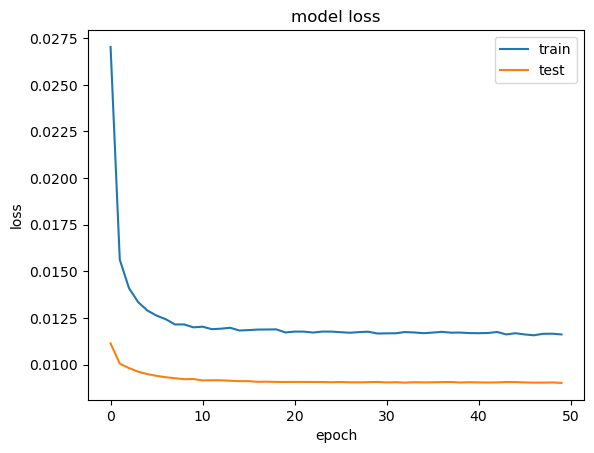

  1/956 [..............................] - ETA: 9:30

2023-09-09 17:12:32.321406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 17:12:32.324106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 17:12:32.325892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

956/956 [==============================] - 3s 2ms/step
Test RMSE: 0.611


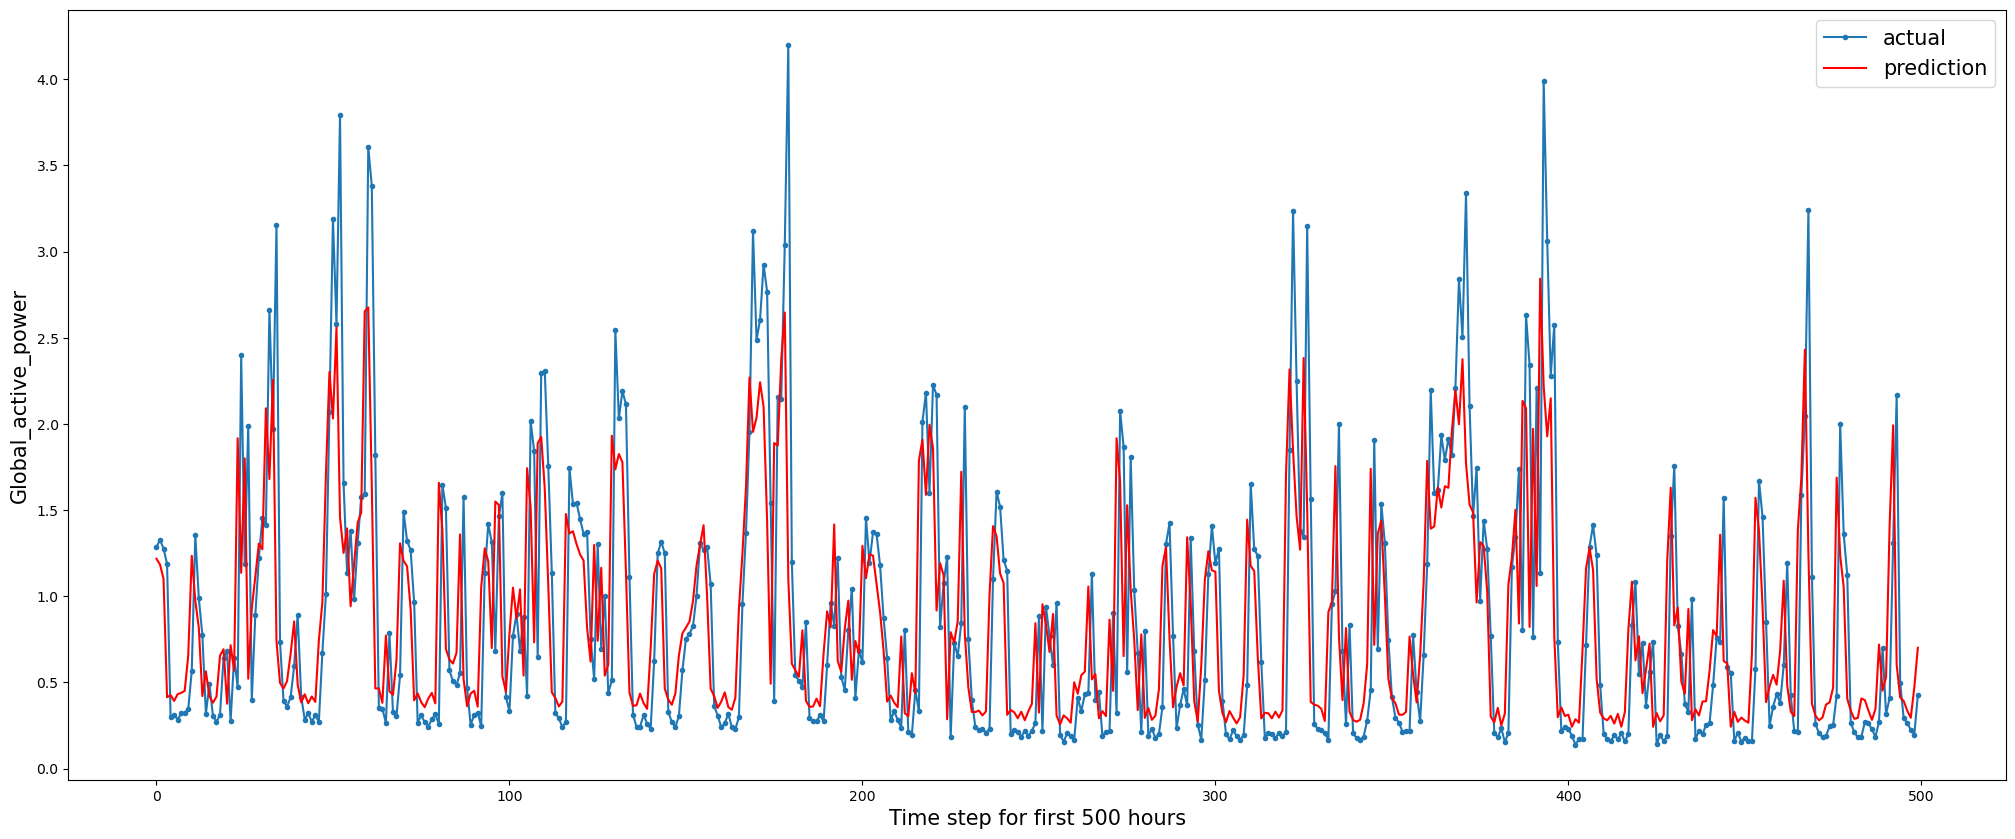

In [10]:
import tensorflow as tf

# Force TensorFlow to use the CPU
tf.config.set_visible_devices([], 'GPU')


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

Source:

https://thecleverprogrammer.com/2021/01/23/energy-consumption-prediction-with-machine-learning/